In [ ]:
!pip install -q transformers
!pip install -q easyocr

In [ ]:
from transformers import AutoModelForObjectDetection
model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")

config.json:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

In [ ]:
model.config.id2label

{0: 'table', 1: 'table rotated'}

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

TableTransformerForObjectDetection(
  (model): TableTransformerModel(
    (backbone): TableTransformerConvModel(
      (conv_encoder): TableTransformerConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): TableTransformerFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBasicLayer(
                    (shortcut): Identity()
                    (layer): Sequential(
                      (0): ResNetConvLayer(
                        (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(

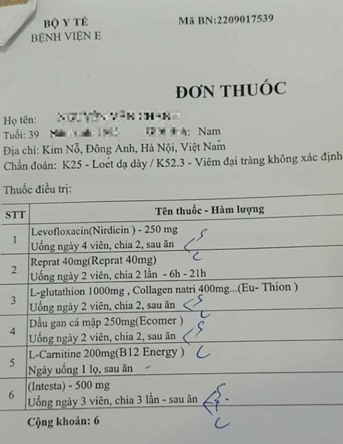

In [ ]:
from PIL import Image
from huggingface_hub import hf_hub_download

file_path = '/content/Test.png'
image = Image.open(file_path).convert("RGB")
width, height = image.size
display(image.resize((int(0.6*width), (int(0.6*height)))))

In [ ]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
pixel_values = detection_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 800, 618])


In [ ]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)

In [ ]:
outputs

TableTransformerObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[ -3.8661, -15.1365,   0.2501],
         [ -6.8434, -16.2709,   4.0768],
         [ -4.2649, -11.5546,   4.6066],
         [ -5.6445, -16.5414,   1.8328],
         [ -4.2554, -10.2379,   4.7999],
         [  1.3996,  -9.4220,  -4.6406],
         [ -4.8273, -17.1384,   2.3950],
         [ -4.7493, -15.9196,   0.7898],
         [ -6.8876,  -8.0362,   5.5745],
         [ -3.8356, -17.0732,   2.0313],
         [ -4.5393, -17.8559,   1.4541],
         [ -6.1829, -15.6517,   2.6019],
         [ -3.6176, -16.4681,   1.5093],
         [ -5.4320, -13.5440,   2.0526],
         [ -4.6014, -13.7443,   0.7924]]], device='cuda:0'), pred_boxes=tensor([[[0.4384, 0.7137, 0.8437, 0.4376],
         [0.8446, 0.7762, 0.2473, 0.2905],
         [0.4630, 0.0520, 0.9096, 0.0934],
         [0.2305, 0.7319, 0.4684, 0.4573],
         [0.5023, 0.0266, 0.9601, 0.0550],
         [0.4396, 0.7041, 0.8518, 0.4677],
         [0.4357, 0.5533

In [ ]:
outputs.logits.shape

torch.Size([1, 15, 3])

In [ ]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

In [ ]:
objects = outputs_to_objects(outputs, image.size, id2label)

In [ ]:
print(objects)

[{'label': 'table', 'score': 0.9976046085357666, 'bbox': [7.849428653717041, 348.50250244140625, 495.089599609375, 695.0392456054688]}]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()

    for det_table in det_tables:
        bbox = det_table['bbox']

        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        else:
            continue

        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor='none',facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)

    plt.xticks([], [])
    plt.yticks([], [])

    legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45),
                                label='Table', hatch='//////', alpha=0.3),
                        Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),
                                label='Table (rotated)', hatch='//////', alpha=0.3)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0,
                    fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis('off')

    if out_path is not None:
      plt.savefig(out_path, bbox_inches='tight', dpi=150)

    return fig

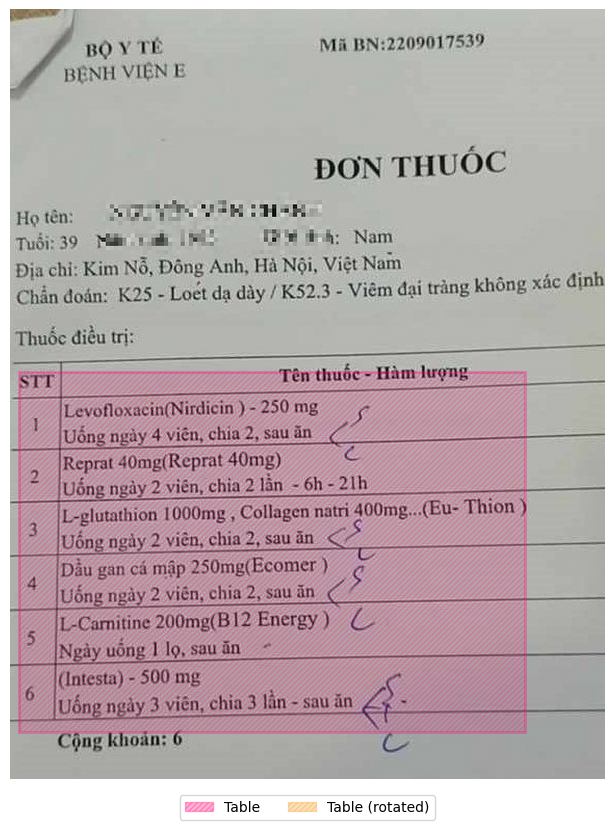

In [ ]:
fig = visualize_detected_tables(image, objects)

In [ ]:
visualized_image = fig2img(fig)

In [ ]:
objects

[{'label': 'table',
  'score': 0.9976046085357666,
  'bbox': [7.849428653717041,
   348.50250244140625,
   495.089599609375,
   695.0392456054688]}]

In [ ]:
def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
    """
    Process the bounding boxes produced by the table detection model into
    cropped table images and cropped tokens.
    """
    table_crops = []
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue

        cropped_table = {}

        bbox = obj['bbox']
        bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]

        cropped_img = img.crop(bbox)

        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [token['bbox'][0]-bbox[0],
                             token['bbox'][1]-bbox[1],
                             token['bbox'][2]-bbox[0],
                             token['bbox'][3]-bbox[1]]

        # If table is predicted to be rotated, rotate cropped image and tokens/words:
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [cropped_img.size[0]-bbox[3]-1,
                        bbox[0],
                        cropped_img.size[0]-bbox[1]-1,
                        bbox[2]]
                token['bbox'] = bbox

        cropped_table['image'] = cropped_img
        cropped_table['tokens'] = table_tokens

        table_crops.append(cropped_table)

    return table_crops

In [ ]:
#For 2 object detect
#count=0
#for obj in objects:
  #if obj['label'] == 'table':
           #count+=1

#count

In [ ]:
tokens = []
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}
crop_padding = 10

tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=0)
cropped_table = tables_crops[0]['image'].convert("RGB")
cropped_table

cropped_table.save('table.png')

In [ ]:
#list_size=[]

#for i in range(count):
#   cropped_table = tables_crops[i]['image'].convert("RGB")
#   display(cropped_table)
#   list_size.append(cropped_table.size)
#   cropped_table.save(f"table{i}.png")

#print(cropped_table.size)
#print(list_size)

In [ ]:
from transformers import TableTransformerForObjectDetection

structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)

config.json:   0%|          | 0.00/76.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

TableTransformerForObjectDetection(
  (model): TableTransformerModel(
    (backbone): TableTransformerConvModel(
      (conv_encoder): TableTransformerConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): TableTransformerFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBasicLayer(
                    (shortcut): Identity()
                    (layer): Sequential(
                      (0): ResNetConvLayer(
                        (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [ ]:
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
pixel_values = structure_transform(cropped_table).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 710, 1000])


In [ ]:
with torch.no_grad():
  outputs = structure_model(pixel_values)

In [ ]:
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
print(cells)

[{'label': 'table row', 'score': 0.9988963603973389, 'bbox': [0.03166896104812622, 21.694534301757812, 486.97076416015625, 71.33275604248047]}, {'label': 'table column', 'score': 0.9998555183410645, 'bbox': [33.902870178222656, -0.16060322523117065, 486.75970458984375, 332.88397216796875]}, {'label': 'table column header', 'score': 0.8596715331077576, 'bbox': [0.021306157112121582, -0.04765958711504936, 486.9739990234375, 20.258230209350586]}, {'label': 'table row', 'score': 0.9987046718597412, 'bbox': [-0.00560230016708374, 72.2504653930664, 486.9335021972656, 121.94821166992188]}, {'label': 'table row', 'score': 0.9983342289924622, 'bbox': [-0.0010740160942077637, 228.4626922607422, 486.94488525390625, 282.0575866699219]}, {'label': 'table row', 'score': 0.9994298815727234, 'bbox': [0.0051378607749938965, 122.81256103515625, 486.962646484375, 174.0352783203125]}, {'label': 'table', 'score': 0.9999449253082275, 'bbox': [0.002235114574432373, -0.08035832643508911, 486.95782470703125, 3

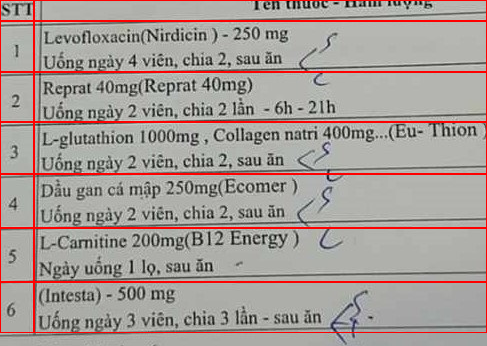

In [ ]:
from PIL import ImageDraw

cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

In [ ]:
def plot_results(cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError("Class should be one of the available classes")

    plt.figure(figsize=(16,10))
    plt.imshow(cropped_table)
    ax = plt.gca()

    for cell in cells:
        score = cell["score"]
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
          text = f'{cell["label"]}: {score:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
          plt.axis('off')

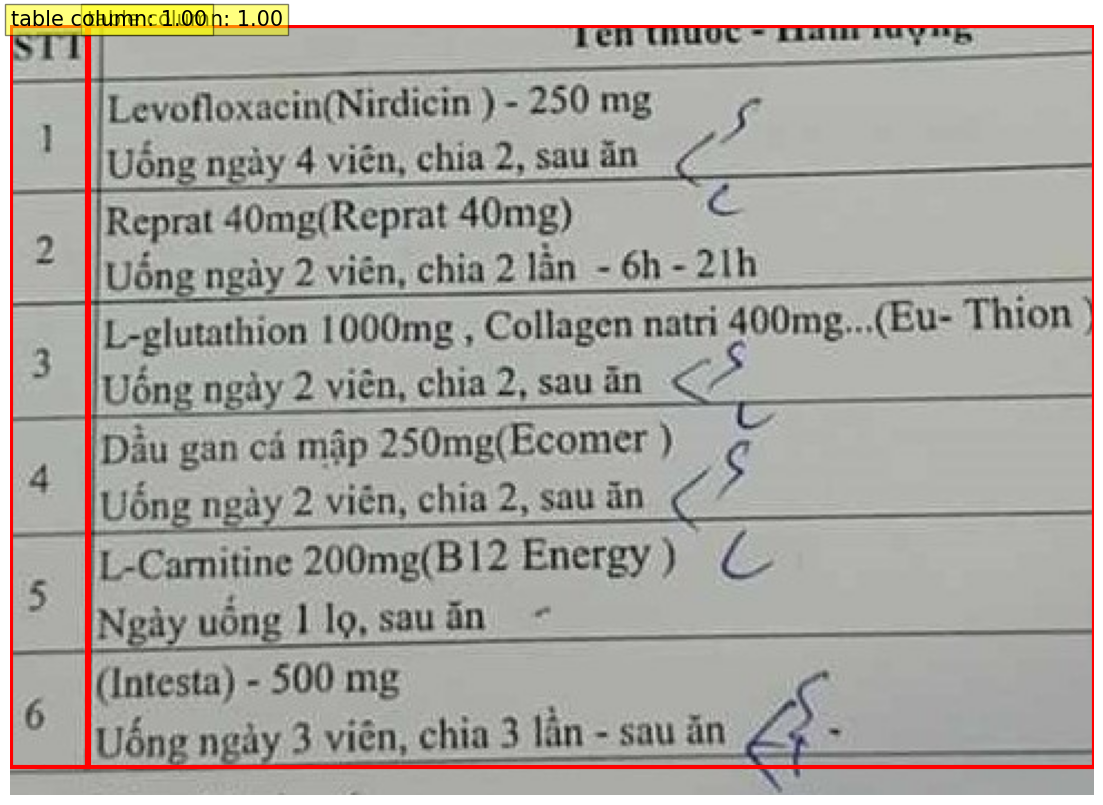

In [ ]:
plot_results(cells, class_to_visualize="table column")

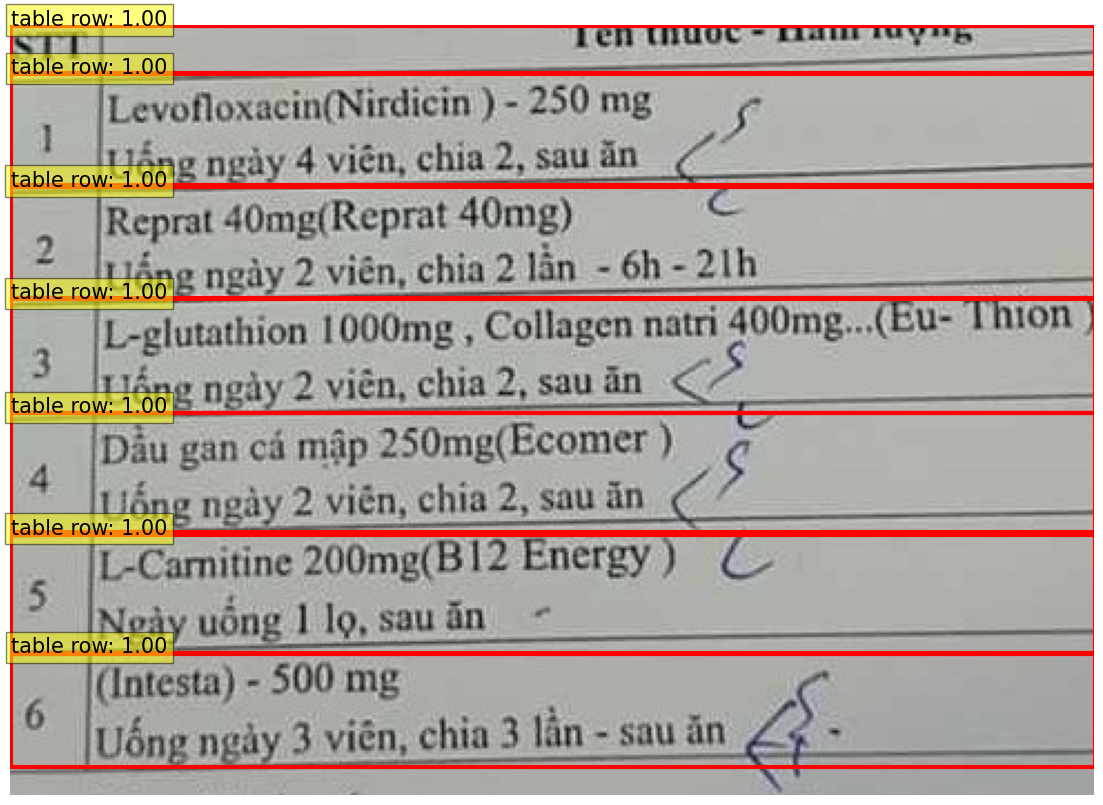

In [ ]:
plot_results(cells, class_to_visualize="table row")

In [ ]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])

        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])

    return cell_coordinates

cell_coordinates = get_cell_coordinates_by_row(cells)

In [ ]:
cell_coordinates

[{'row': [0.045892417430877686,
   -0.07265813648700714,
   487.0093994140625,
   20.937301635742188],
  'cells': [{'column': [-0.1227172240614891,
     -0.2091502547264099,
     34.83998107910156,
     332.846435546875],
    'cell': [-0.1227172240614891,
     -0.07265813648700714,
     34.83998107910156,
     20.937301635742188]},
   {'column': [33.902870178222656,
     -0.16060322523117065,
     486.75970458984375,
     332.88397216796875],
    'cell': [33.902870178222656,
     -0.07265813648700714,
     486.75970458984375,
     20.937301635742188]}],
  'cell_count': 2},
 {'row': [0.03166896104812622,
   21.694534301757812,
   486.97076416015625,
   71.33275604248047],
  'cells': [{'column': [-0.1227172240614891,
     -0.2091502547264099,
     34.83998107910156,
     332.846435546875],
    'cell': [-0.1227172240614891,
     21.694534301757812,
     34.83998107910156,
     71.33275604248047]},
   {'column': [33.902870178222656,
     -0.16060322523117065,
     486.75970458984375,
     

In [ ]:
len(cell_coordinates)

7

In [ ]:
len(cell_coordinates[0]["cells"]) #columns

2

In [ ]:
for row in cell_coordinates:
  print(row["cells"])

[{'column': [-0.1227172240614891, -0.2091502547264099, 34.83998107910156, 332.846435546875], 'cell': [-0.1227172240614891, -0.07265813648700714, 34.83998107910156, 20.937301635742188]}, {'column': [33.902870178222656, -0.16060322523117065, 486.75970458984375, 332.88397216796875], 'cell': [33.902870178222656, -0.07265813648700714, 486.75970458984375, 20.937301635742188]}]
[{'column': [-0.1227172240614891, -0.2091502547264099, 34.83998107910156, 332.846435546875], 'cell': [-0.1227172240614891, 21.694534301757812, 34.83998107910156, 71.33275604248047]}, {'column': [33.902870178222656, -0.16060322523117065, 486.75970458984375, 332.88397216796875], 'cell': [33.902870178222656, 21.694534301757812, 486.75970458984375, 71.33275604248047]}]
[{'column': [-0.1227172240614891, -0.2091502547264099, 34.83998107910156, 332.846435546875], 'cell': [-0.1227172240614891, 72.2504653930664, 34.83998107910156, 121.94821166992188]}, {'column': [33.902870178222656, -0.16060322523117065, 486.75970458984375, 33

In [ ]:
#!pip install easyocr

In [ ]:
import numpy as np
import csv
import easyocr
from tqdm.auto import tqdm

reader = easyocr.Reader(['en','vi'])
def apply_ocr(cell_coordinates):
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(tqdm(cell_coordinates)):
      row_text = []
      for cell in row["cells"]:
        cell_image = np.array(cropped_table.crop(cell["cell"]))
        result = reader.readtext(np.array(cell_image))
        if len(result) > 0:
          text = " ".join([x[1] for x in result])
          row_text.append(text)

      if len(row_text) > max_num_columns:
          max_num_columns = len(row_text)

      data[idx] = row_text

    print("Max number of columns:", max_num_columns)

    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
          row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data

    return data

data = apply_ocr(cell_coordinates)

for row, row_data in data.items():
    print(row_data)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

  0%|          | 0/7 [00:00<?, ?it/s]

Max number of columns: 2
['STT', 'Ien (uuC']
['Levofloxacin(Nirdicin ) - 250 mg [Uóng npày 4 vién, chia 2. sau ẳn', '']
['Reprat 4Omg(Reprat 40mg) [Uóng ngày 2 vienchia 2 làn 6h - 2Ih', '']
['[L-glutathion IOOOmg , Collagen natri 4OOmg- (Eu- Thion Uông ngày 2 viên, chia 2 sau &n', '']
['[Dẩu gan cá mp 250mg(Ecomer luóng ngày 2 viên; chia 2, sau &n', '']
['L-Camitinc 200mg(B12 Energy [Ngày uong 1o, sau ún', '']
['(Intesta ) 500 Uống ngẳy 3 viên; chia 3 lan sau án mg', '']


In [ ]:
import csv
with open('output.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')

    for row, row_text in data.items():
      wr.writerow(row_text)

In [ ]:
import pandas as pd
df = pd.read_csv("output.csv")
df

STT  Ien (uuC
0  Levofloxacin(Nirdicin ) - 250 mg [Uóng npày 4 ...       NaN
1  Reprat 4Omg(Reprat 40mg) [Uóng ngày 2 vienchia...       NaN
2  [L-glutathion IOOOmg , Collagen natri 4OOmg- (...       NaN
3  [Dẩu gan cá mp 250mg(Ecomer luóng ngày 2 viên;...       NaN
4  L-Camitinc 200mg(B12 Energy [Ngày uong 1o, sau ún       NaN
5  (Intesta ) 500 Uống ngẳy 3 viên; chia 3 lan sa...       NaN

In [ ]:
!pip install pytesseract
!apt-get install tesseract-ocr
!apt-get install tesseract-ocr-vie

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,943 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [ ]:
# USE TESSERACT
import pytesseract
import cv2

def apply_ocr(cell_coordinates):
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(tqdm(cell_coordinates)):
        row_text = []
        for cell in row["cells"]:
            cell_image = np.array(cropped_table.crop(cell["cell"]))
            # Apply OCR using Tesseract
            text = pytesseract.image_to_string(cell_image, lang='vie')
            row_text.append(text)

        if len(row_text) > max_num_columns:
            max_num_columns = len(row_text)

        data[idx] = row_text
    print("Max number of columns:", max_num_columns)

    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
            row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data

    return data

data = apply_ocr(cell_coordinates)

for row, row_data in data.items():
    print(row_data)

  0%|          | 0/7 [00:00<?, ?it/s]

Max number of columns: 2
['\x0c', 'AE SN S5, s.\n\n \n\x0c']
['\x0c', ' \n\x0c']
['\x0c', 'Reprat 40mg(Reprat 40mg) C\nUống ngày 2 viên, chia 2 lẫn - 6h -21h\n\x0c']
['\x0c', 'L~glutathion 1000mg , Collagen natri . „(Eu- Ihion ¿j\nUống ngày 2 viên, chia 2, sau ăn. <2\n\x0c']
['\x0c', 'Dầu gan cá mập 250mg(Ecomer) œ\nUống ngày 2 viên, chia 2, sau ăn (Í D\n\x0c']
['bo |\n\x0c', '|L-Camitine 200mg(B12 Energy)\n\n \n\n \n\x0c']
['\x0c', ' \n\n(Intesta) - 500 mg,\nUống ngày 3 viên, chỉa 3 lần - sau ăn 4 x\n\x0c']


In [ ]:
import csv

with open('output.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')

    for row, row_text in data.items():
      wr.writerow(row_text)

In [ ]:
import pandas as pd

df = pd.read_csv("output.csv")
df

AE SN S5, s.\n\n \n

0        
                                                \n

1        
  Reprat 40mg(Reprat 40mg) C\nUống ngày 2 viên, ...
2        
  L~glutathion 1000mg , Collagen natri . „(Eu- I...
3        
  Dầu gan cá mập 250mg(Ecomer) œ\nUống ngày 2 vi...
4  bo |\n
         |L-Camitine 200mg(B12 Energy)\n\n \n\n \n

5        
   \n\n(Intesta) - 500 mg,\nUống ngày 3 viên, ch...

<>:66: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:133: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:66: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:133: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-49-6c73762b50cf>:66: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (i != 0 and len(lines_x1) is not 0):
<ipython-input-49-6c73762b50cf>:133: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (count != 0 and len(lines_y1) is not 0):


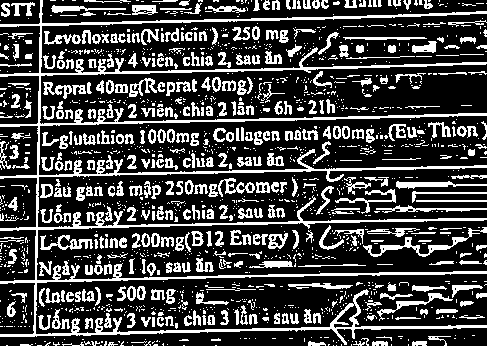

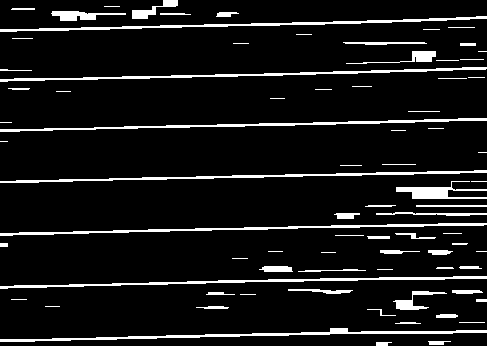

52
(346, 487, 3)


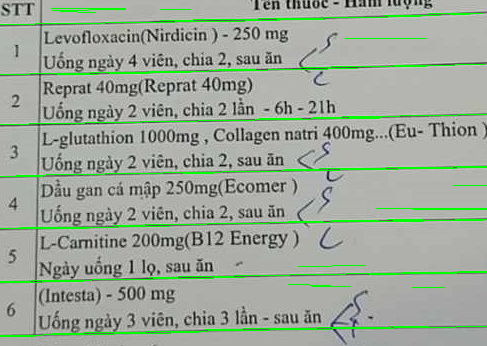

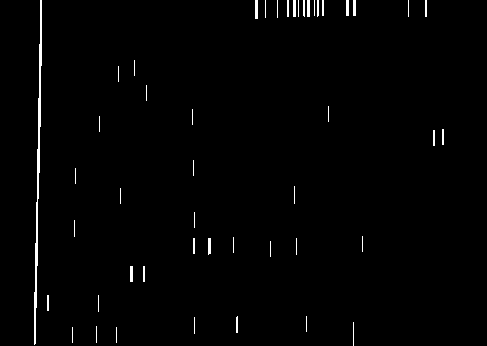

10
(346, 487, 3)


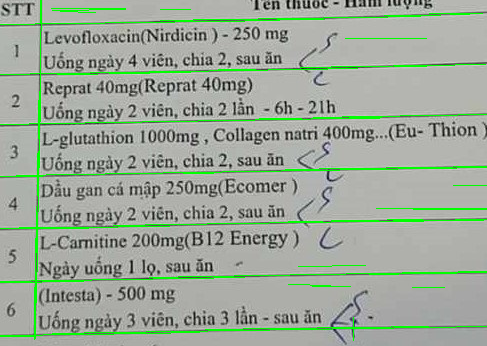

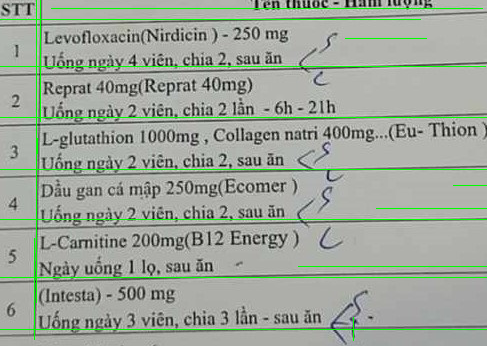

Total lines: 17


([[51, 8, 482, 8],
  [0, 19, 420, 19],
  [345, 38, 426, 38],
  [0, 66, 485, 66],
  [0, 117, 486, 117],
  [0, 169, 486, 169],
  [453, 185, 486, 185],
  [376, 208, 486, 208],
  [0, 219, 486, 219],
  [298, 266, 486, 266],
  [0, 277, 486, 277],
  [0, 329, 486, 329]],
 [[34, 238, 34, 339],
  [36, -5, 36, 302],
  [37, 138, 37, 153],
  [40, -5, 40, 121],
  [353, 317, 353, 340]],
 17)

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def line_detection(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 1)
    bw = cv2.bitwise_not(bw)
    ## To visualize image after thresholding ##
    cv2_imshow(bw)
    cv2.waitKey(0)
    ###########################################
    horizontal = bw.copy()
    vertical = bw.copy()
    img = image.copy()
    # [horizontal lines]
    # Create structure element for extracting horizontal lines through morphology operations
    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 1))

    # Apply morphology operations
    horizontal = cv2.erode(horizontal, horizontalStructure)
    horizontal = cv2.dilate(horizontal, horizontalStructure)

    horizontal = cv2.dilate(horizontal, (1,1), iterations=5)
    horizontal = cv2.erode(horizontal, (1,1), iterations=5)

    ## Uncomment to visualize highlighted Horizontal lines
    cv2_imshow(horizontal)
    cv2.waitKey(0)

    # HoughlinesP function to detect horizontal lines
    hor_lines = cv2.HoughLinesP(horizontal,rho=1,theta=np.pi/180,threshold=100,minLineLength=30,maxLineGap=3)
    if hor_lines is None:
        return None,None
    temp_line = []
    for line in hor_lines:
        for x1,y1,x2,y2 in line:
            temp_line.append([x1,y1-5,x2,y2-5])

    # Sorting the list of detected lines by Y1
    hor_lines = sorted(temp_line,key=lambda x: x[1])

    ## Uncomment this part to visualize the lines detected on the image ##
    print(len(hor_lines))
    for x1, y1, x2, y2 in hor_lines:
        cv2.line(image, (x1,y1), (x2,y2), (0, 255, 0), 1)


    print(image.shape)
    cv2_imshow(image)
    cv2.waitKey(0)
    ####################################################################

    ## Selection of best lines from all the horizontal lines detected ##
    lasty1 = -111111
    lines_x1 = []
    lines_x2 = []
    hor = []
    i=0
    for x1,y1,x2,y2 in hor_lines:
        if y1 >= lasty1 and y1 <= lasty1 + 10:
            lines_x1.append(x1)
            lines_x2.append(x2)
        else:
            if (i != 0 and len(lines_x1) is not 0):
                hor.append([min(lines_x1),lasty1,max(lines_x2),lasty1])
            lasty1 = y1
            lines_x1 = []
            lines_x2 = []
            lines_x1.append(x1)
            lines_x2.append(x2)
            i+=1
    hor.append([min(lines_x1),lasty1,max(lines_x2),lasty1])
    #####################################################################


    # [vertical lines]
    # Create structure element for extracting vertical lines through morphology operations
    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 15))

    # Apply morphology operations
    vertical = cv2.erode(vertical, verticalStructure)
    vertical = cv2.dilate(vertical, verticalStructure)

    vertical = cv2.dilate(vertical, (1,1), iterations=8)
    vertical = cv2.erode(vertical, (1,1), iterations=7)

    ######## Preprocessing Vertical Lines ###############
    cv2_imshow(vertical)
    cv2.waitKey(0)
    #####################################################

    # HoughlinesP function to detect vertical lines
    #ver_lines = cv2.HoughLinesP(vertical,rho=1,theta=np.pi/180,threshold=20,minLineLength=20,maxLineGap=2)
    ver_lines = cv2.HoughLinesP(vertical, 1, np.pi/180, 20, np.array([]), 20, 2)
    if ver_lines is None:
        return None,None
    temp_line = []
    for line in ver_lines:
        for x1,y1,x2,y2 in line:
            temp_line.append([x1,y1,x2,y2])

    # Sorting the list of detected lines by X1
    ver_lines = sorted(temp_line,key=lambda x: x[0])

    ## Uncomment this part to visualize the lines detected on the image ##
    print(len(ver_lines))
    for x1, y1, x2, y2 in ver_lines:
        cv2.line(image, (x1,y1-5), (x2,y2-5), (0, 255, 0), 1)


    print(image.shape)
    cv2_imshow(image)
    cv2.waitKey(0)
    ####################################################################

    ## Selection of best lines from all the vertical lines detected ##
    lastx1 = -111111
    lines_y1 = []
    lines_y2 = []
    ver = []
    count = 0
    lasty1 = -11111
    lasty2 = -11111
    for x1,y1,x2,y2 in ver_lines:
        if x1 >= lastx1 and x1 <= lastx1 + 15 and not (((min(y1,y2)<min(lasty1,lasty2)-20 or min(y1,y2)<min(lasty1,lasty2)+20)) and ((max(y1,y2)<max(lasty1,lasty2)-20 or max(y1,y2)<max(lasty1,lasty2)+20))):
            lines_y1.append(y1)
            lines_y2.append(y2)
            lasty1 = y1
            lasty2 = y2
        else:
            if (count != 0 and len(lines_y1) is not 0):
                ver.append([lastx1,min(lines_y2)-5,lastx1,max(lines_y1)-5])
            lastx1 = x1
            lines_y1 = []
            lines_y2 = []
            lines_y1.append(y1)
            lines_y2.append(y2)
            count += 1
            lasty1 = -11111
            lasty2 = -11111
    ver.append([lastx1,min(lines_y2)-5,lastx1,max(lines_y1)-5])
    #################################################################


    ############ Visualization of Lines After Post Processing ############
    for x1, y1, x2, y2 in ver:
        cv2.line(img, (x1,y1), (x2,y2), (0, 255, 0), 1)

    for x1, y1, x2, y2 in hor:
        cv2.line(img, (x1,y1), (x2,y2), (0, 255, 0), 1)

    cv2_imshow(img)
    cv2.waitKey(0)
    #######################################################################

#!!! Count line
    num_vertical_lines = len(ver)
    num_horizontal_lines = len(hor)
    total_lines = num_vertical_lines + num_horizontal_lines

    # Print the number of lines (consider adjusting for specific needs)
    print("Total lines:", total_lines)

    return hor,ver, total_lines

line_detection(cv2.imread('/content/table.png'))


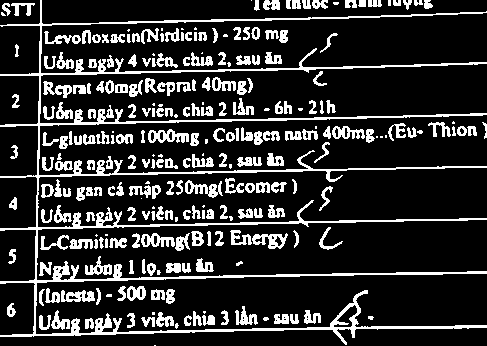

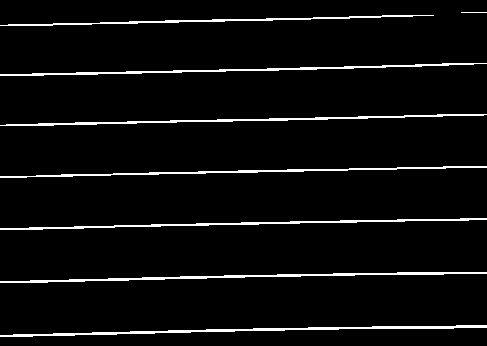

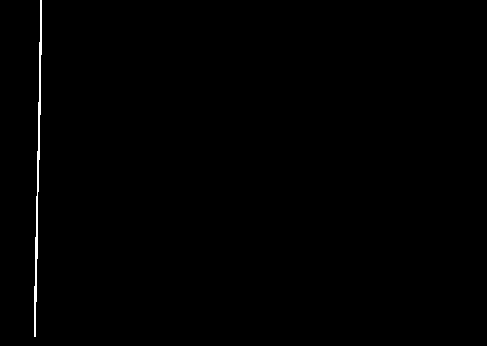

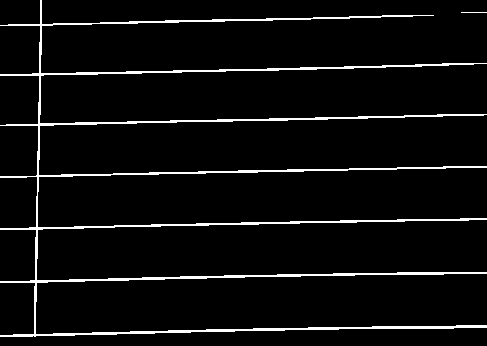

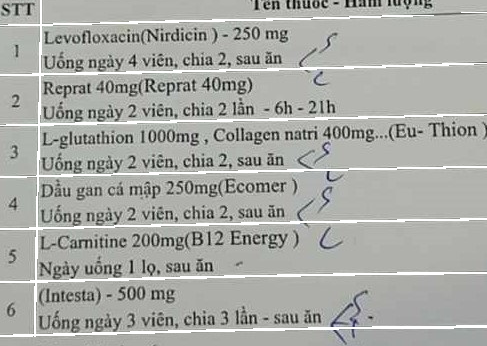

-1

In [ ]:
import cv2
import numpy as np

# Load image, grayscale, Gaussian blur, Otsu's threshold
image = cv2.imread('/content/table.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Detect horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,1))
horizontal_mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)

# Detect vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,50))
vertical_mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=1)

# Combine masks and remove lines
table_mask = cv2.bitwise_or(horizontal_mask, vertical_mask)
image[np.where(table_mask==255)] = [255,255,255]

cv2_imshow(thresh)
cv2_imshow(horizontal_mask)
cv2_imshow(vertical_mask)
cv2_imshow(table_mask)
cv2_imshow(image)
cv2.waitKey()

486
331
[array([[384, 272, 486, 271]], dtype=int32), array([[100,  71, 241,  69]], dtype=int32), array([[223, 224, 486, 220]], dtype=int32), array([[171, 278, 438, 274]], dtype=int32), array([[130, 224, 316, 221]], dtype=int32), array([[347,  16, 471,  12]], dtype=int32), array([[257, 330, 428, 328]], dtype=int32), array([[371, 169, 486, 167]], dtype=int32), array([[216, 170, 364, 168]], dtype=int32), array([[ 76, 332, 193, 330]], dtype=int32), array([[154, 122, 340, 119]], dtype=int32), array([[ 69, 122, 195, 120]], dtype=int32), array([[337,  66, 486,  61]], dtype=int32), array([[ 39, 180,  42,   0]], dtype=int32), array([[153,  22, 292,  20]], dtype=int32), array([[214, 132, 373, 130]], dtype=int32), array([[ 37, 143, 416, 136]], dtype=int32), array([[ 51, 141, 317, 137]], dtype=int32), array([[ 35, 272,  40,   0]], dtype=int32), array([[104, 334, 217, 331]], dtype=int32), array([[141, 142, 317, 139]], dtype=int32), array([[ 38, 218, 243, 218]], dtype=int32), array([[ 33, 319, 214, 

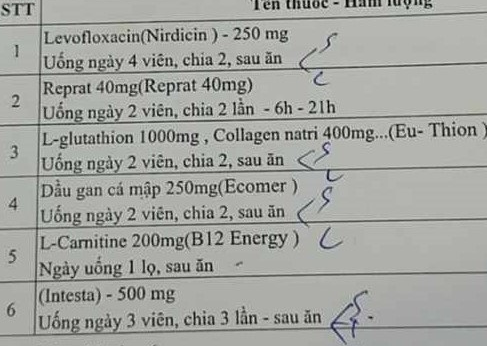

In [ ]:
import cv2
import numpy as np

def detect_table_lines(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection to find edges
    edges = cv2.Canny(gray, 50, 150)

    # Apply Hough line transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

    # Filter out lines based on length and orientation
    filtered_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi

        # Exclude lines that are too short or have orientations close to horizontal or vertical
        if length > 100 and (angle < 80 or angle > 100):
            filtered_lines.append(line)

# !!! X2_max
    x2_max=0
    for line in filtered_lines:
        x1, y1, x2, y2 = line[0]
        if x2 > x2_max:
           x2_max = x2

    y2_max=0
    for line in filtered_lines:
        x1, y1, x2, y2 = line[0]
        if y2 > y2_max:
           y2_max = y2

    print(x2_max)
    print(y2_max)
    print(filtered_lines)
    print(len(filtered_lines))
    # Draw detected lines on the image
    for line in filtered_lines:
        x1, y1, x2, y2 = line[0]

# !!! 0 - 10
        if 0 <= x1 <=10 and x2==x2_max :
          cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        if 0 <= y1 <=10 and y2==y2_max :
          cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Display the image with detected lines
    cv2_imshow(image)
    cv2.destroyAllWindows()

# Specify the path to the image containing the table
image_path = '/content/table.png'
#image_path = '/content/BHX_2.jpg'

# Detect lines in the table image
detect_table_lines(image_path)

# TEST

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.4 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import hf_hub_download
from transformers import AutoImageProcessor, TableTransformerForObjectDetection
import torch
from PIL import Image

file_path = '/content/Test.png'
image = Image.open(file_path).convert("RGB")

image_processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-detection")
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[
    0
]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Detected table with confidence 0.997 at location [7.79, 348.11, 495.51, 699.99]


In [ ]:
from transformers import AutoImageProcessor, TableTransformerModel
from huggingface_hub import hf_hub_download
from PIL import Image

image_processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-detection")
model = TableTransformerModel.from_pretrained("microsoft/table-transformer-detection")

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

# forward pass
outputs = model(**inputs)

# the last hidden states are the final query embeddings of the Transformer decoder
# these are of shape (batch_size, num_queries, hidden_size)
last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


[1, 15, 256]

In [ ]:
from transformers import TableTransformerModel, TableTransformerConfig

# Initializing a Table Transformer microsoft/table-transformer-detection style configuration
configuration = TableTransformerConfig()

# Initializing a model from the microsoft/table-transformer-detection style configuration
model = TableTransformerModel(configuration)

# Accessing the model configuration
configuration = model.config

configuration

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

TableTransformerConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "attention_dropout": 0.0,
  "auxiliary_loss": false,
  "backbone": "resnet50",
  "backbone_config": null,
  "backbone_kwargs": null,
  "bbox_cost": 5,
  "bbox_loss_coefficient": 5,
  "class_cost": 1,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "dice_loss_coefficient": 1,
  "dilation": false,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_coefficient": 0.1,
  "giou_cost": 2,
  "giou_loss_coefficient": 2,
  "init_std": 0.02,
  "init_xavier_std": 1.0,
  "is_encoder_decoder": true,
  "mask_loss_coefficient": 1,
  "model_type": "table-transformer",
  "num_channels": 3,
  "num_hidden_layers": 6,
  "num_queries": 100,
  "position_embedding_type": "sine",
  "transformers_version": "4.40.0",
  "use_pretrained_backbone": true,
  "use_tim

In [ ]:
from PIL import Image
from transformers import DetrImageProcessor
from transformers import TableTransformerForObjectDetection

import torch
import matplotlib.pyplot as plt
import os
import psutil
import time
from transformers import DetrFeatureExtractor
feature_extractor = DetrFeatureExtractor()
import pandas as pd

!pip -q install pytesseract pillow pandas
import pytesseract

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint

In [ ]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
def table_detection(file_path):
    image = Image.open(file_path).convert("RGB")
    width, height = image.size
    image.resize((int(width*0.5), int(height*0.5)))

    feature_extractor = DetrImageProcessor()
    encoding = feature_extractor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)

    width, height = image.size
    results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]
    plot_results(image, results['scores'], results['labels'], results['boxes'])
    return results['boxes']

In [ ]:
ram_usage = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024

print(f"ram usage : {ram_usage}")

ram usage : 2678.3046875


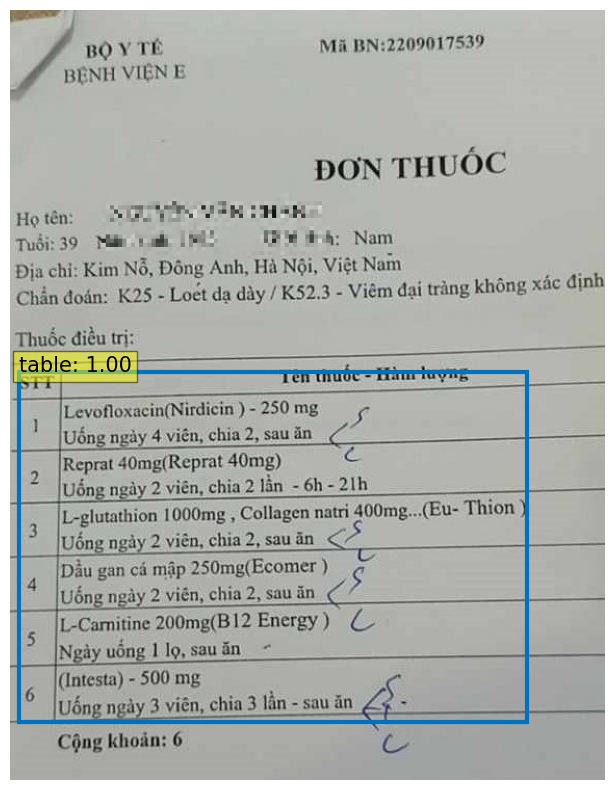

Iteration 1 - RAM Usage: 2764.18 MB, Time Usage: 2.09 seconds


In [ ]:
count = 0

#for file in os.listdir(root):
file_path = '/content/Test.png'
start_time = time.time()
pred_bbox = table_detection(file_path)


end_time = time.time()
time_usage = end_time - start_time
ram_usage = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024

print(f"Iteration {count + 1} - RAM Usage: {ram_usage:.2f} MB, Time Usage: {time_usage:.2f} seconds")


In [ ]:
def plot_results_specific(pil_img, scores, labels, boxes,lab):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        if label == lab:
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color=c, linewidth=3))
            text = f'{model.config.id2label[label]}: {score:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
def draw_box_specific(image_path,labelnum):
    image = Image.open(image_path).convert("RGB")
    width, height = image.size

    encoding = feature_extractor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)

    results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]
    plot_results_specific(image, results['scores'], results['labels'], results['boxes'],labelnum)

In [ ]:
def compute_boxes(image_path):
    image = Image.open(image_path).convert("RGB")
    width, height = image.size

    encoding = feature_extractor(image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**encoding)

    results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]
    boxes = results['boxes'].tolist()
    labels = results['labels'].tolist()

    return boxes,labels

In [ ]:
custom_config = r'--oem 3 --psm 6 -l vie'

In [ ]:
def extract_table(image_path):
    image = Image.open(image_path).convert("RGB")
    boxes,labels = compute_boxes(image_path)

    cell_locations = []

    for box_row, label_row in zip(boxes, labels):
        if label_row == 2:
            for box_col, label_col in zip(boxes, labels):
                if label_col == 1:
                    cell_box = (box_col[0], box_row[1], box_col[2], box_row[3])
                    cell_locations.append(cell_box)

    cell_locations.sort(key=lambda x: (x[1], x[0]))

    num_columns = 0
    box_old = cell_locations[0]

    for box in cell_locations[1:]:
        x1, y1, x2, y2 = box
        x1_old, y1_old, x2_old, y2_old = box_old
        num_columns += 1
        if y1 > y1_old:
            break

        box_old = box

    headers = []
    for box in cell_locations[:num_columns]:
        x1, y1, x2, y2 = box
        cell_image = image.crop((x1, y1, x2, y2))
        new_width = cell_image.width * 4
        new_height = cell_image.height * 4
        cell_image = cell_image.resize((new_width, new_height), resample=Image.LANCZOS)
        cell_text = pytesseract.image_to_string(cell_image)
        headers.append(cell_text.rstrip())

    df = pd.DataFrame(columns=headers)

    row = []
    for box in cell_locations[num_columns:]:
        x1, y1, x2, y2 = box
        cell_image = image.crop((x1, y1, x2, y2))
        new_width = cell_image.width * 4
        new_height = cell_image.height * 4
        cell_image = cell_image.resize((new_width, new_height), resample=Image.LANCZOS)
        cell_text = pytesseract.image_to_string(cell_image, config=custom_config)

        if len(cell_text) > num_columns:
            cell_text = cell_text[:num_columns]

        row.append(cell_text.rstrip())

        if len(row) == num_columns:
            df.loc[len(df)] = row
            row = []

    return df

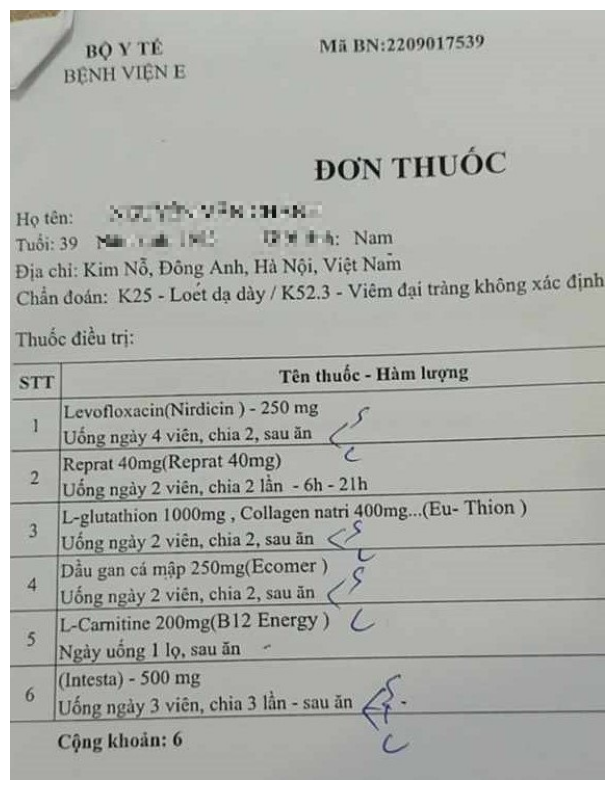

IndexError: list index out of range

In [ ]:
image_path = '/content/Test.png'
draw_box_specific(image_path,1)
df = extract_table(image_path)
df.to_csv('data.csv', index=False)

In [ ]:
df

In [ ]:
df = pd.read_csv('data.csv')
display(df)